In [44]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt 

# Data Cleaning

In [45]:
data = pd.read_csv("data/car_price.csv")

In [46]:
data.isnull().any()

Unnamed: 0             False
car_name               False
car_prices_in_rupee    False
kms_driven             False
fuel_type              False
transmission           False
ownership              False
manufacture            False
engine                 False
Seats                  False
dtype: bool

In [47]:
data.shape

(5512, 10)

In [48]:
data.head(1)

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats


In [49]:
data.dtypes

Unnamed: 0              int64
car_name               object
car_prices_in_rupee    object
kms_driven             object
fuel_type              object
transmission           object
ownership              object
manufacture             int64
engine                 object
Seats                  object
dtype: object

In [50]:
data.drop(columns = 'Unnamed: 0',inplace=True)

In [51]:
data["engine_vol"] = data.engine.str.replace(" cc","").astype(int)

In [52]:
def convert_to_usd(amount): 
    if 'Lakh' in amount:
        rupees = float(amount.split(' ')[0]) * 100_000
        
    elif 'Crore' in amount:
        rupees = float(amount.split(' ')[0]) * 10_000_000
        
    else:
        rupees = float(amount.replace(',', ''))
    
    usd = rupees * .012 
    return usd


In [53]:
data["car_price_usd"] = data["car_prices_in_rupee"].apply(convert_to_usd)

<Axes: >

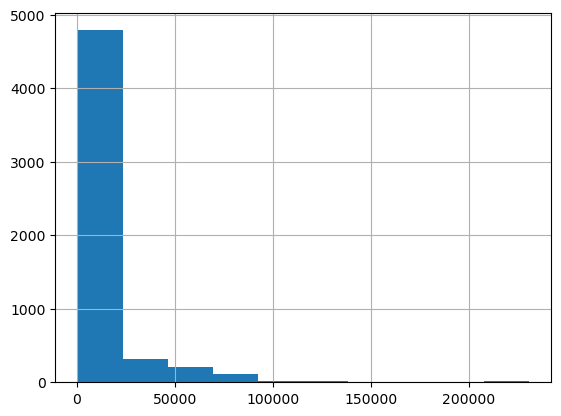

In [54]:
data.car_price_usd.hist()

In [55]:
data["kms_driven"] = data["kms_driven"].str.replace(",","").str.split().str[0].astype(int)

In [56]:
data["car_brand"] = data.car_name.str.split().str[0]

In [57]:
cols_to_drop = ["car_prices_in_rupee", "car_name", "engine"]
cleaned_data = data.drop(columns=cols_to_drop)
cleaned_data.columns = cleaned_data.columns.str.lower()
cleaned_data

,kms_driven,fuel_type,transmission,ownership,manufacture,seats,engine_vol,car_price_usd,car_brand
0,86226,Diesel,Manual,1st Owner,2017,5 Seats,1956,12036.0,Jeep
1,13248,Petrol,Automatic,1st Owner,2021,5 Seats,1330,15396.0,Renault
2,60343,Petrol,Automatic,1st Owner,2016,5 Seats,2494,19680.0,Toyota
3,26696,Petrol,Automatic,1st Owner,2018,5 Seats,1199,9324.0,Honda
4,69414,Petrol,Manual,1st Owner,2016,5 Seats,1199,6180.0,Volkswagen
...,...,...,...,...,...,...,...,...,...
5507,45000,Diesel,Automatic,1st Owner,2018,7 Seats,2995,34680.0,BMW
5508,29000,Petrol,Automatic,2nd Owner,2015,5 Seats,1968,77880.0,BMW
5509,90000,Diesel,Automatic,2nd Owner,2013,5 Seats,2755,16500.0,Jaguar
5510,79000,Diesel,Automatic,3rd Owner,2015,6 Seats,2967,35880.0,BMW


In [58]:
cleaned_data.car_brand.unique()

array(['Jeep', 'Renault', 'Toyota', 'Honda', 'Volkswagen', 'Maruti',
       'Mahindra', 'Hyundai', 'Nissan', 'Kia', 'MG', 'Tata', 'BMW',
       'Mercedes-Benz', 'Datsun', 'Volvo', 'Audi', 'Porsche', 'Ford',
       'Chevrolet', 'Skoda', 'Lexus', 'Land', 'Mini', 'Jaguar',
       'Mitsubishi', 'Force', 'Premier', 'Fiat', 'Maserati', 'Bentley',
       'Isuzu'], dtype=object)

In [59]:
brand_country_map = {'Jeep': 'United States', 'Renault': 'France', 'Toyota': 'Japan','Honda': 'Japan','Volkswagen': 'Germany','Maruti': 'India','Mahindra': 'India','Hyundai': 'South Korea',
    'Nissan': 'Japan', 'Kia': 'South Korea', 'MG': 'United Kingdom', 'Tata': 'India', 'BMW': 'Germany', 'Mercedes-Benz': 'Germany', 
    'Datsun': 'Japan', 'Volvo': 'Sweden', 'Audi': 'Germany', 'Porsche': 'Germany', 
    'Ford': 'United States', 'Chevrolet': 'United States', 'Skoda': 'Czech Republic', 'Lexus': 'Japan', 
    'Land': 'United Kingdom', 'Mini': 'United Kingdom',
    'Jaguar': 'United Kingdom', 'Mitsubishi': 'Japan', 'Force': 'India', 'Premier': 'India', 'Fiat': 'Italy',
    'Maserati': 'Italy', 'Bentley': 'United Kingdom', 'Isuzu': 'Japan'}

In [60]:
cleaned_data["car_country"] = cleaned_data['car_brand'].map(brand_country_map)

In [61]:
cleaned_data["car_country"].unique()

array(['United States', 'France', 'Japan', 'Germany', 'India',
       'South Korea', 'United Kingdom', 'Sweden', 'Czech Republic',
       'Italy'], dtype=object)

In [62]:
country_region_map = {
    'United States': 'North America',
    'France': 'Europe',
    'Japan': 'East Asia',
    'Germany': 'Europe',
    'India': 'South Asia',
    'South Korea': 'East Asia',
    'United Kingdom': 'Europe',
    'Sweden': 'Europe',
    'Czech Republic': 'Europe',
    'Italy': 'Europe' }

In [63]:
cleaned_data["car_region"] = cleaned_data["car_country"].map(country_region_map)

In [64]:
cleaned_data.car_region.unique()

array(['North America', 'Europe', 'East Asia', 'South Asia'], dtype=object)

#  Multicollinearity check

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
y, X = dmatrices('car_price_usd~kms_driven + fuel_type + seats + ownership + transmission + manufacture +car_region+engine_vol',
                  data=cleaned_data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

       VIF Factor                     features
0   427603.320439                    Intercept
1       18.036324          fuel_type[T.Diesel]
2        1.188303        fuel_type[T.Electric]
3        1.367009             fuel_type[T.Lpg]
4       18.033758          fuel_type[T.Petrol]
5       18.364376             seats[T.4 Seats]
6      142.870315             seats[T.5 Seats]
7       13.099909             seats[T.6 Seats]
8      113.003551             seats[T.7 Seats]
9       11.735584             seats[T.8 Seats]
10     173.616622       ownership[T.1st Owner]
11     145.353982       ownership[T.2nd Owner]
12      49.609548       ownership[T.3rd Owner]
13      13.020550       ownership[T.4th Owner]
14       2.750166       ownership[T.5th Owner]
15       1.577881       transmission[T.Manual]
16       1.718414         car_region[T.Europe]
17       1.112072  car_region[T.North America]
18       1.346225     car_region[T.South Asia]
19       1.521569                   kms_driven
20       1.60

`ownership` high multicollinearity drop it

In [66]:
y, X = dmatrices('car_price_usd~kms_driven + seats+ fuel_type + transmission + manufacture +car_region+engine_vol',
                  data=cleaned_data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

       VIF Factor                     features
0   372037.313751                    Intercept
1       18.347415             seats[T.4 Seats]
2      142.739093             seats[T.5 Seats]
3       13.075215             seats[T.6 Seats]
4      112.894972             seats[T.7 Seats]
5       11.726738             seats[T.8 Seats]
6       18.012458          fuel_type[T.Diesel]
7        1.187933        fuel_type[T.Electric]
8        1.364974             fuel_type[T.Lpg]
9       18.016093          fuel_type[T.Petrol]
10       1.577466       transmission[T.Manual]
11       1.711312         car_region[T.Europe]
12       1.111098  car_region[T.North America]
13       1.345362     car_region[T.South Asia]
14       1.510709                   kms_driven
15       1.399634                  manufacture
16       1.074809                   engine_vol


`seats` also high multicollinearity drop it 

In [67]:
y, X = dmatrices('car_price_usd~kms_driven + fuel_type + transmission + manufacture +car_region+engine_vol',
                  data=cleaned_data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

       VIF Factor                     features
0   370344.057773                    Intercept
1       17.997305          fuel_type[T.Diesel]
2        1.186357        fuel_type[T.Electric]
3        1.363300             fuel_type[T.Lpg]
4       18.009594          fuel_type[T.Petrol]
5        1.575767       transmission[T.Manual]
6        1.705949         car_region[T.Europe]
7        1.110114  car_region[T.North America]
8        1.344389     car_region[T.South Asia]
9        1.510234                   kms_driven
10       1.398884                  manufacture
11       1.041795                   engine_vol


`fuel type` still has some multicollinearity issue. Lets try combining the features

In [68]:
cleaned_data.fuel_type.unique()

array(['Diesel', 'Petrol', 'Cng', 'Electric', 'Lpg'], dtype=object)

In [69]:
cleaned_data["fuel_type"] = cleaned_data.fuel_type.apply(lambda x: '1' if x =="Electric" else '0')

In [70]:
y, X = dmatrices('car_price_usd~kms_driven + fuel_type + transmission + manufacture +car_region+engine_vol',
                  data=cleaned_data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

      VIF Factor                     features
0  356291.654631                    Intercept
1       1.012310               fuel_type[T.1]
2       1.569281       transmission[T.Manual]
3       1.633312         car_region[T.Europe]
4       1.094634  car_region[T.North America]
5       1.318861     car_region[T.South Asia]
6       1.315114                   kms_driven
7       1.348468                  manufacture
8       1.038523                   engine_vol


No more multicollinearity after combining features

# Fit initial model 1

In [71]:
cleaned_data

,kms_driven,fuel_type,transmission,ownership,manufacture,seats,engine_vol,car_price_usd,car_brand,car_country,car_region
0,86226,0,Manual,1st Owner,2017,5 Seats,1956,12036.0,Jeep,United States,North America
1,13248,0,Automatic,1st Owner,2021,5 Seats,1330,15396.0,Renault,France,Europe
2,60343,0,Automatic,1st Owner,2016,5 Seats,2494,19680.0,Toyota,Japan,East Asia
3,26696,0,Automatic,1st Owner,2018,5 Seats,1199,9324.0,Honda,Japan,East Asia
4,69414,0,Manual,1st Owner,2016,5 Seats,1199,6180.0,Volkswagen,Germany,Europe
...,...,...,...,...,...,...,...,...,...,...,...
5507,45000,0,Automatic,1st Owner,2018,7 Seats,2995,34680.0,BMW,Germany,Europe
5508,29000,0,Automatic,2nd Owner,2015,5 Seats,1968,77880.0,BMW,Germany,Europe
5509,90000,0,Automatic,2nd Owner,2013,5 Seats,2755,16500.0,Jaguar,United Kingdom,Europe
5510,79000,0,Automatic,3rd Owner,2015,6 Seats,2967,35880.0,BMW,Germany,Europe


In [72]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                cleaned_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     432.0
Date:                Mon, 09 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:14:23   Log-Likelihood:                -61987.
No. Observations:                5512   AIC:                         1.240e+05
Df Residuals:                    5503   BIC:                         1.241e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -2.593e+06   1.49e+05    -17.396      0.000   -2.89e+06    -2.3e+06
fuel_type[T.1]              -1.629e+04   4991.880     -3.264      0.001   -2.61e+04   -6507.073
transmission[T.Manual]      -1.692e+04    695.827    -24.312      0.000   -1.83e+04   -1.56e+04
car_region[T.Europe]         1.363e+04    755.225     18.053      0.000    1.22e+04    1.51e+04
car_region[T.North America]   782.4313   1153.530      0.678      0.498   -1478.943    3043.806
car_region[T.South Asia]    -1201.4137    598.098     -2.009      0.045   -2373.922     -28.906
kms_driven                     -0.0207      0.007     -3.027      0.002      -0.034      -0.007
manufacture                  1297.1127     73.834     17.568      0.000    1152.369    1441.856
engine_vol                      2.2721      0.439      5.171      0.000       1.411       3.134
==============================================================================
Omnibus:                     5889.305   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           491914.073
Skew:                           5.355   Prob(JB):                         0.00
Kurtosis:                      48.024   Cond. No.                     4.53e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.53e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Influential Points

In [73]:
infl = model.get_influence()

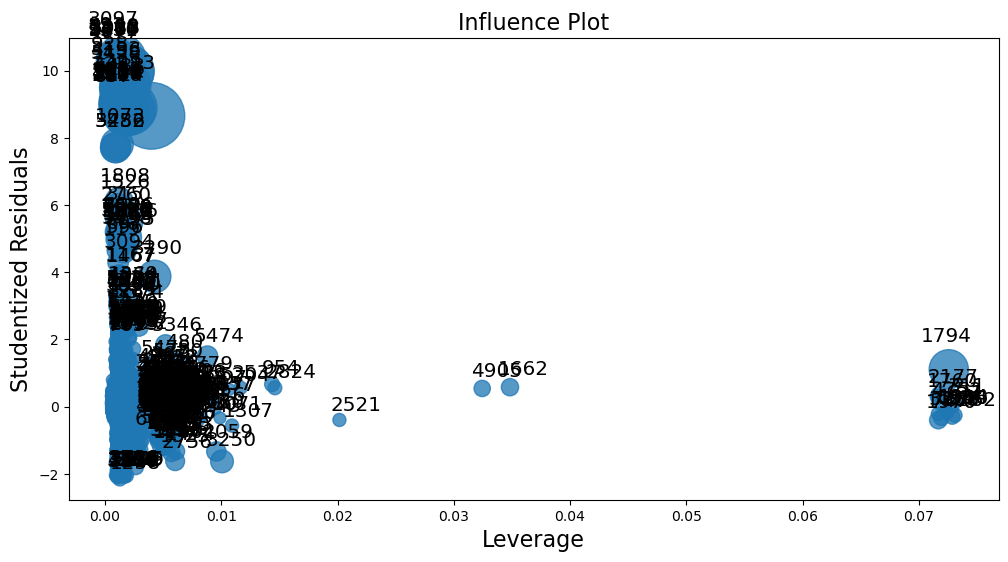

In [74]:
fig, ax = plt.subplots(figsize=(12,6))
fig=sm.graphics.influence_plot(model,ax=ax, criterion="cooks") 

In [75]:
import scipy
n=5512
p=9
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
print(cleaned_data.index[atyp_stud],reg_studs[atyp_stud])

Index([ 119,  205,  227,  283,  315,  370,  596,  607,  632,  697,
       ...
       5370, 5374, 5406, 5422, 5438, 5458, 5470, 5482, 5483, 5508],
      dtype='int64', length=130) [ 4.65664403  2.04279537  2.15954949  2.29210903  5.50145304  2.377561
  4.64706822  2.09361637  2.58708766  4.74189941  1.98080382  2.29156244
  2.31294654  2.24444313  8.74119277  5.28700009 -2.04111984  2.94017808
 10.30077261  2.103491    9.56605657  8.8842174   7.80316963  9.04276302
  2.54190311  3.92192252  2.35295535  2.27594711  2.3645642   3.20539326
  2.20819799 -2.14648059  8.88995414  5.14511154  2.96819948  2.44189681
  1.99682249 10.20304638  2.22409371  3.39186209  2.48027612  3.90380284
  2.41469285 10.16269784  2.30248599  5.04493903  2.42008766  5.94953149
  3.19907423  2.21977412  8.88346119 -1.97252452  2.0629314   6.11007501
  2.47518831  2.07365861 -2.01246403 -2.05816714 -2.03139428  2.33271168
 -2.01746534  5.61486533  2.06751323  8.89460192  8.9687859   3.27208451
  2.34261797  9.9777

In [76]:
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(cleaned_data.index[atyp_cook],reg_cook[atyp_cook])

Index([ 119,  283,  288,  315,  370,  480,  596,  632,  697,  747,
       ...
       5370, 5374, 5406, 5422, 5438, 5458, 5470, 5474, 5482, 5483],
      dtype='int64', length=119) 119     0.002673
283     0.001086
288     0.000790
315     0.006406
370     0.001830
          ...   
5458    0.015222
5470    0.000803
5474    0.002229
5482    0.005976
5483    0.019456
Name: cooks_d, Length: 119, dtype: float64


In [77]:
infl_points = cleaned_data.index[atyp_cook & atyp_stud]

## Heteroscedasticity

In [78]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 290.17164387630635, 'LM-Test p-value': 5.078815186397392e-58}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

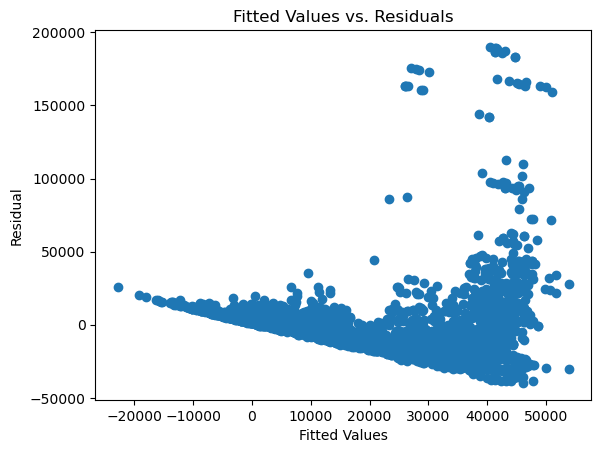

In [79]:
p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

## Normality

In [80]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     432.0
Date:                Mon, 09 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:14:42   Log-Likelihood:                -61987.
No. Observations:                5512   AIC:                         1.240e+05
Df Residuals:                    5503   BIC:                         1.241e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -2.593e+06   1.49e+05    -17.396      0.000   -2.89e+06    -2.3e+06
fuel_type[T.1]              -1.629e+04   4991.880     -3.264      0.001   -2.61e+04   -6507.073
transmission[T.Manual]      -1.692e+04    695.827    -24.312      0.000   -1.83e+04   -1.56e+04
car_region[T.Europe]         1.363e+04    755.225     18.053      0.000    1.22e+04    1.51e+04
car_region[T.North America]   782.4313   1153.530      0.678      0.498   -1478.943    3043.806
car_region[T.South Asia]    -1201.4137    598.098     -2.009      0.045   -2373.922     -28.906
kms_driven                     -0.0207      0.007     -3.027      0.002      -0.034      -0.007
manufacture                  1297.1127     73.834     17.568      0.000    1152.369    1441.856
engine_vol                      2.2721      0.439      5.171      0.000       1.411       3.134
==============================================================================
Omnibus:                     5889.305   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           491914.073
Skew:                           5.355   Prob(JB):                         0.00
Kurtosis:                      48.024   Cond. No.                     4.53e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.53e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

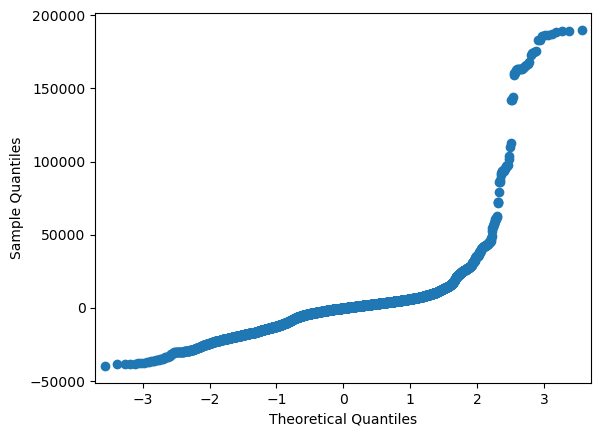

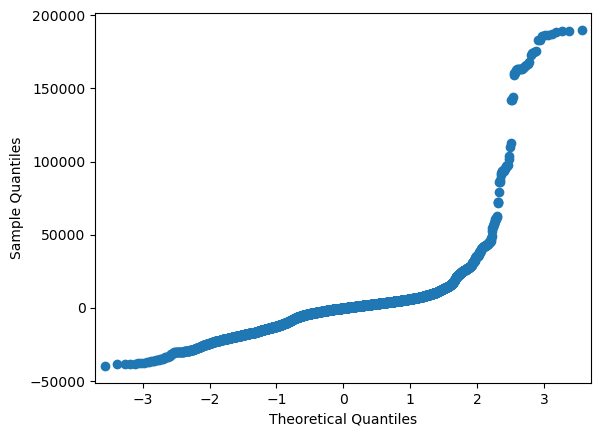

In [81]:
sm.qqplot(model.resid)

All assumptions violated. Next step is to refit the model after 

* Removing influential points 
* Log transform y

# Fit model 2

In [82]:
cleaned_data_v2 = cleaned_data.drop(infl_points)

In [83]:
cleaned_data_v2["car_price_usd"] = np.log(cleaned_data_v2["car_price_usd"])

In [84]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                cleaned_data_v2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     1752.
Date:                Mon, 09 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:14:42   Log-Likelihood:                -4036.0
No. Observations:                5417   AIC:                             8090.
Df Residuals:                    5408   BIC:                             8149.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    -270.5116      4.117    -65.700      0.000    -278.583    -262.440
fuel_type[T.1]                 -0.5451      0.137     -3.967      0.000      -0.814      -0.276
transmission[T.Manual]         -0.8296      0.019    -43.007      0.000      -0.867      -0.792
car_region[T.Europe]            0.4266      0.021     20.256      0.000       0.385       0.468
car_region[T.North America]    -0.0997      0.032     -3.139      0.002      -0.162      -0.037
car_region[T.South Asia]       -0.1642      0.016     -9.965      0.000      -0.196      -0.132
kms_driven                   1.194e-06   1.89e-07      6.324      0.000    8.24e-07    1.56e-06
manufacture                     0.1388      0.002     68.050      0.000       0.135       0.143
engine_vol                      0.0001   1.23e-05      8.530      0.000    8.07e-05       0.000
==============================================================================
Omnibus:                       52.117   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.235
Skew:                          -0.158   Prob(JB):                     6.83e-15
Kurtosis:                       3.435   Cond. No.                     4.53e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.53e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Influential points

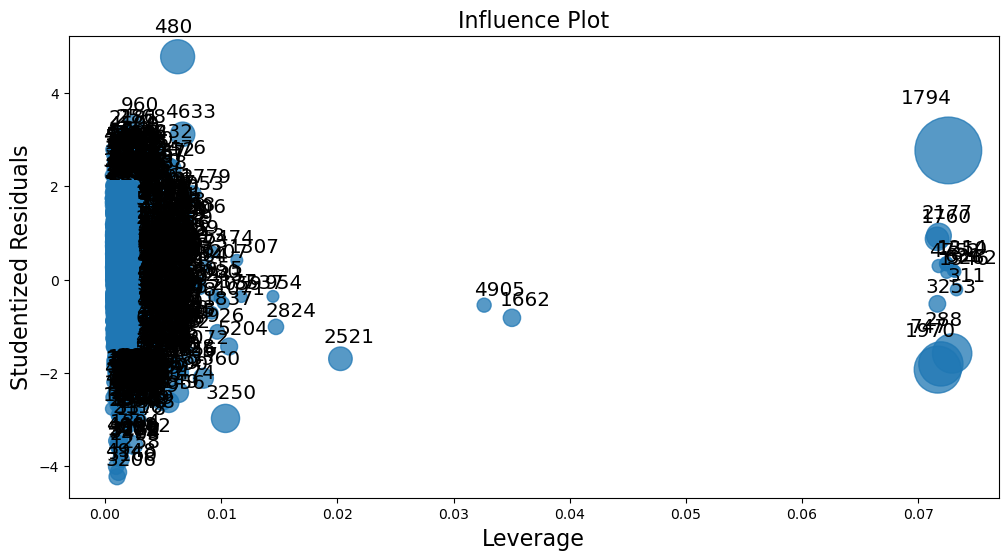

In [85]:
infl = model.get_influence()
fig, ax = plt.subplots(figsize=(12,6))
fig=sm.graphics.influence_plot(model,ax=ax, criterion="cooks") 

In [86]:
import scipy
n=5417
p=9
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
print(cleaned_data_v2.index[atyp_stud],reg_studs[atyp_stud])

Index([  22,   39,   45,   53,   73,  134,  152,  182,  191,  281,
       ...
       5348, 5366, 5386, 5388, 5402, 5409, 5428, 5430, 5441, 5508],
      dtype='int64', length=274) [-1.97082444 -1.98807358 -2.01134843 -3.10615713 -2.35048718 -2.11828331
  2.37339018 -2.29861735 -2.10694569  2.21335355  3.11970269  2.32175146
  2.26334405  2.66218662 -2.05328563  4.77631706  2.63836423 -2.12289815
  2.2143132  -2.02186317 -2.90303473 -2.03437525  2.82546046 -2.49549007
 -2.16950784  2.1689525   2.27425184 -2.13632863 -2.28376308  2.6499326
  2.25489041 -2.40061968  2.60188739  2.46076242  3.35153385 -1.99083524
 -2.04771026 -2.42942452 -2.52240171 -2.70838178  2.24052474 -3.14408675
  1.96418461  2.34545407  2.05511976  2.3690742  -2.79065732 -3.85232991
 -2.06433549  2.67923748  2.25489041  2.77944376  2.59343657  2.25416448
  1.98771169  2.80415757 -2.70838178  2.61251812  2.24160851 -2.05228601
  2.12002512 -2.42319044  2.50450776 -2.77197358  1.99683139  2.05511976
  2.26617727 -2.997

In [87]:
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(cleaned_data_v2.index[atyp_cook],reg_cook[atyp_cook])

Index([  22,   23,   35,   39,   42,   53,   57,   64,   70,   73,
       ...
       5286, 5294, 5306, 5315, 5348, 5366, 5428, 5437, 5491, 5508],
      dtype='int64', length=325) 22      0.000948
23      0.001266
35      0.000773
39      0.000887
42      0.001096
          ...   
5366    0.001445
5428    0.000739
5437    0.001240
5491    0.000858
5508    0.001035
Name: cooks_d, Length: 325, dtype: float64


In [88]:
infl_points = cleaned_data_v2.index[atyp_cook & atyp_stud]

In [89]:
cleaned_data_v3 = cleaned_data_v2.drop(infl_points)

In [90]:
model_after = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                cleaned_data_v3).fit()
model_after.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     2258.
Date:                Mon, 09 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:14:58   Log-Likelihood:                -3266.0
No. Observations:                5225   AIC:                             6550.
Df Residuals:                    5216   BIC:                             6609.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    -277.5092      3.748    -74.036      0.000    -284.857    -270.161
fuel_type[T.1]                 -0.7095      0.127     -5.608      0.000      -0.958      -0.462
transmission[T.Manual]         -0.8378      0.018    -46.912      0.000      -0.873      -0.803
car_region[T.Europe]            0.4937      0.019     25.374      0.000       0.456       0.532
car_region[T.North America]    -0.0844      0.029     -2.959      0.003      -0.140      -0.028
car_region[T.South Asia]       -0.1347      0.015     -9.100      0.000      -0.164      -0.106
kms_driven                   9.996e-07   1.73e-07      5.774      0.000     6.6e-07    1.34e-06
manufacture                     0.1423      0.002     76.625      0.000       0.139       0.146
engine_vol                      0.0001   1.12e-05      9.579      0.000    8.55e-05       0.000
==============================================================================
Omnibus:                       33.832   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.745
Skew:                          -0.054   Prob(JB):                     4.23e-06
Kurtosis:                       2.681   Cond. No.                     4.55e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.55e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Heteroscedasticity

In [91]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 327.6879425434766, 'LM-Test p-value': 5.206950835264283e-66}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

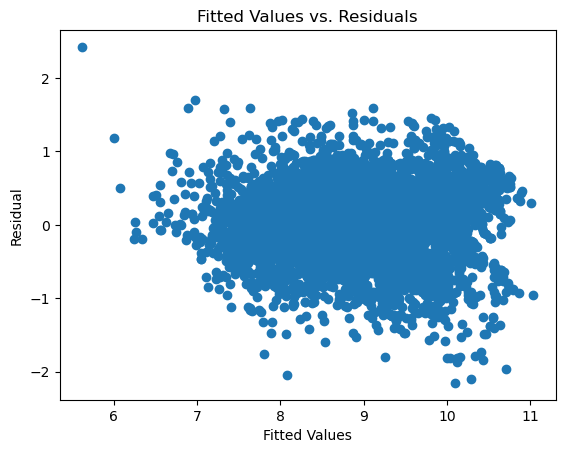

In [92]:
p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

## Normality

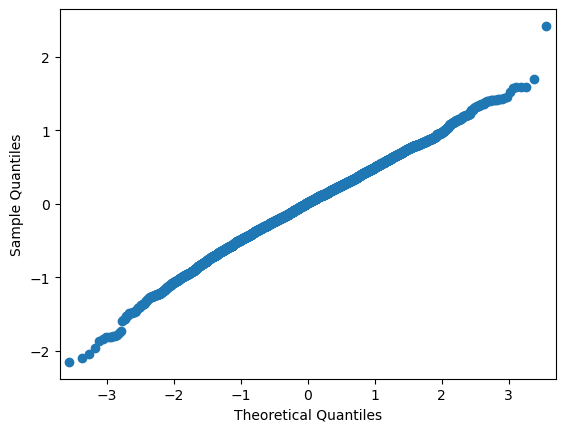

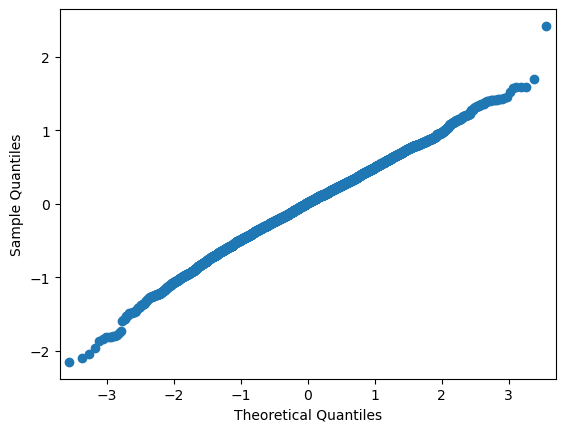

In [93]:
sm.qqplot(model.resid)

# Fitting models by region

# North America

In [94]:
NA_cars = cleaned_data_v2.query("car_region=='North America'")

In [95]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                NA_cars).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     265.5
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           2.98e-96
Time:                        00:14:59   Log-Likelihood:                -199.27
No. Observations:                 299   AIC:                             408.5
Df Residuals:                     294   BIC:                             427.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -405.4933     16.291    -24.890      0.000    -437.555    -373.431
transmission[T.Manual]    -0.7649      0.084     -9.059      0.000      -0.931      -0.599
kms_driven              1.555e-06   7.44e-07      2.090      0.038    9.04e-08    3.02e-06
manufacture                0.2057      0.008     25.499      0.000       0.190       0.222
engine_vol               6.02e-05   4.78e-05      1.259      0.209   -3.39e-05       0.000
==============================================================================
Omnibus:                        5.297   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                5.970
Skew:                           0.180   Prob(JB):                       0.0505
Kurtosis:                       3.591   Cond. No.                     4.91e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.91e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Heteroscedasticity

{'LM Statistic': 11.828760940058803, 'LM-Test p-value': 0.018671124347145594}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

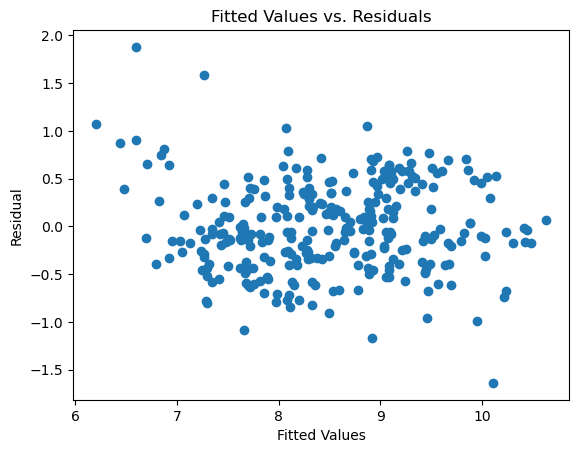

In [96]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

## Normality

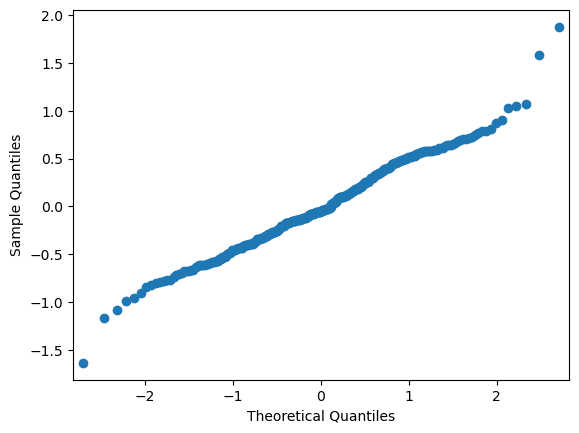

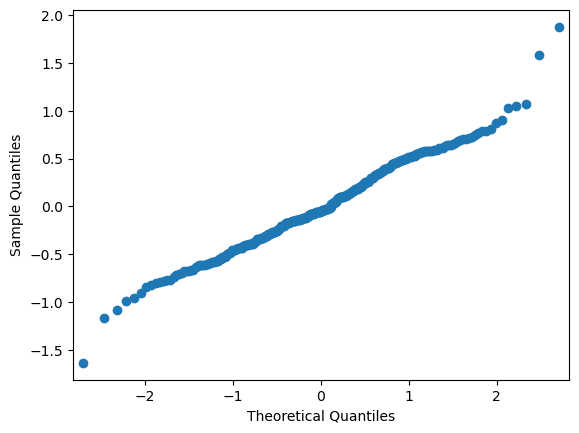

In [97]:
sm.qqplot(model.resid)

# Europe

In [98]:
EU_cars = cleaned_data_v2.query("car_region=='Europe'")

In [99]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                EU_cars).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     599.0
Date:                Mon, 09 Oct 2023   Prob (F-statistic):          1.83e-322
Time:                        00:14:59   Log-Likelihood:                -1024.0
No. Observations:                1201   AIC:                             2060.
Df Residuals:                    1195   BIC:                             2091.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -240.6032     12.812    -18.780      0.000    -265.739    -215.467
fuel_type[T.1]            -0.6200      0.286     -2.168      0.030      -1.181      -0.059
transmission[T.Manual]    -1.4439      0.038    -38.033      0.000      -1.518      -1.369
kms_driven             -1.603e-06   6.16e-07     -2.604      0.009   -2.81e-06   -3.95e-07
manufacture                0.1243      0.006     19.594      0.000       0.112       0.137
engine_vol                 0.0002    2.6e-05      5.872      0.000       0.000       0.000
==============================================================================
Omnibus:                      169.929   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.943
Skew:                          -0.940   Prob(JB):                     3.27e-60
Kurtosis:                       4.393   Cond. No.                     5.11e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'LM Statistic': 60.91703213354183, 'LM-Test p-value': 7.85540485417346e-12}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

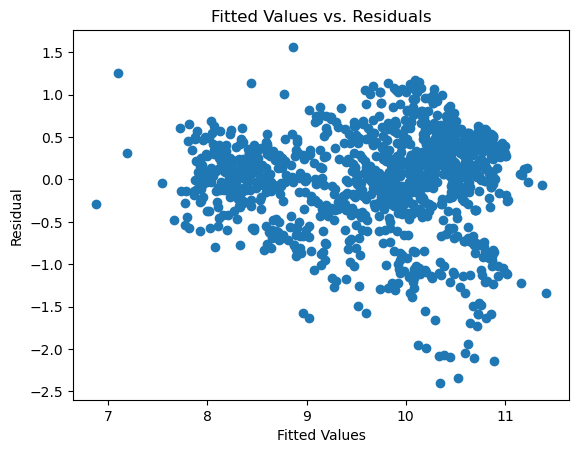

In [100]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

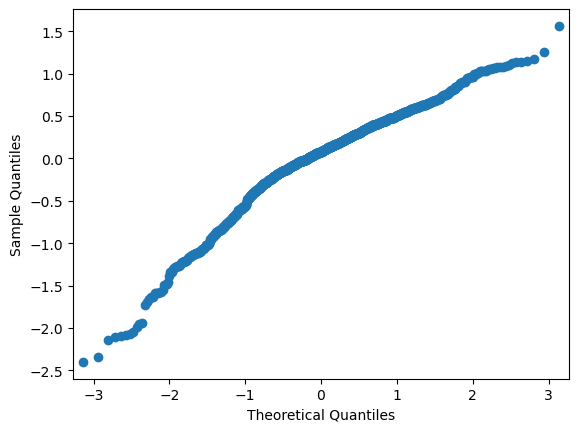

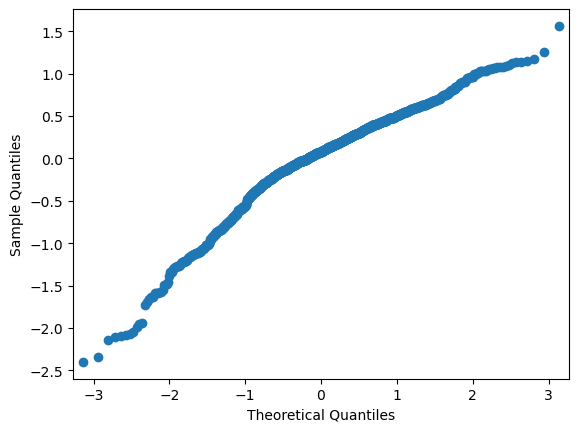

In [101]:
sm.qqplot(model.resid)

# East Asia

In [102]:
EA_cars = cleaned_data_v2.query("car_region=='East Asia'")

In [103]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                EA_cars).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     748.6
Date:                Mon, 09 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:14:59   Log-Likelihood:                -1137.8
No. Observations:                1942   AIC:                             2288.
Df Residuals:                    1936   BIC:                             2321.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -278.7813      6.034    -46.204      0.000    -290.614    -266.948
fuel_type[T.1]             1.0572      0.436      2.424      0.015       0.202       1.912
transmission[T.Manual]    -0.5683      0.026    -22.270      0.000      -0.618      -0.518
kms_driven              2.455e-06   2.74e-07      8.966      0.000    1.92e-06    2.99e-06
manufacture                0.1428      0.003     47.769      0.000       0.137       0.149
engine_vol               7.54e-05   1.89e-05      3.999      0.000    3.84e-05       0.000
==============================================================================
Omnibus:                       85.592   Durbin-Watson:                   1.784
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.470
Skew:                           0.453   Prob(JB):                     2.79e-24
Kurtosis:                       3.721   Cond. No.                     4.68e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'LM Statistic': 79.95364912591448, 'LM-Test p-value': 8.581301536915064e-16}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

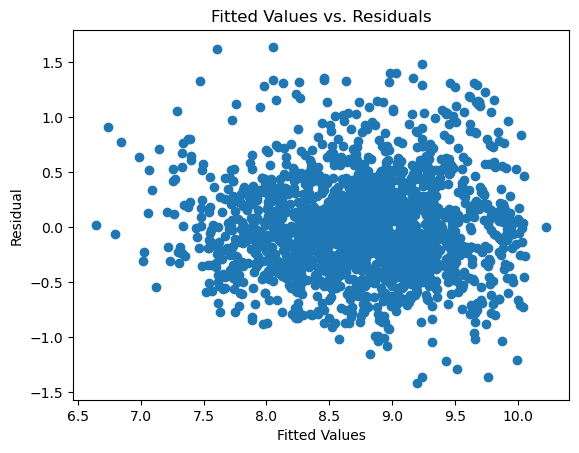

In [104]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))
p = model.fittedvalues

res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

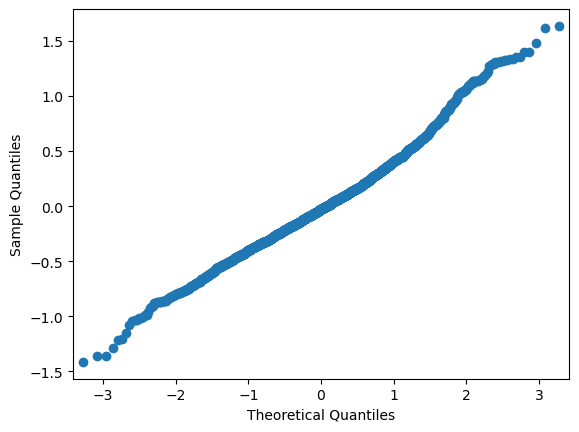

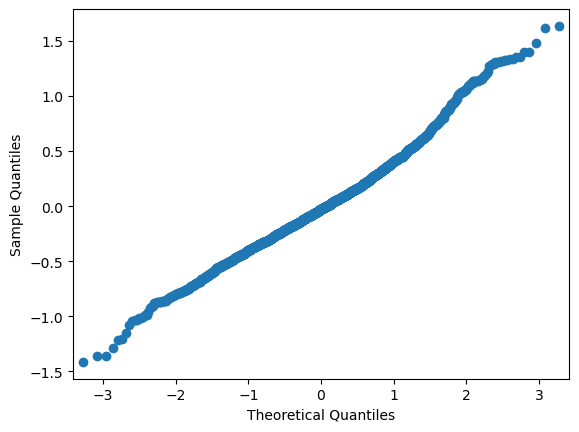

In [105]:
sm.qqplot(model.resid)

# South Asia 

In [106]:
SA_cars = cleaned_data_v2.query("car_region=='South Asia'")

In [107]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                SA_cars).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     694.0
Date:                Mon, 09 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:14:59   Log-Likelihood:                -1169.2
No. Observations:                1975   AIC:                             2350.
Df Residuals:                    1969   BIC:                             2384.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -267.8250      5.238    -51.134      0.000    -278.097    -257.553
fuel_type[T.1]            -0.2720      0.150     -1.811      0.070      -0.567       0.023
transmission[T.Manual]    -0.2905      0.037     -7.915      0.000      -0.362      -0.219
kms_driven              1.075e-06   2.37e-07      4.536      0.000     6.1e-07    1.54e-06
manufacture                0.1372      0.003     52.885      0.000       0.132       0.142
engine_vol               5.08e-05   1.78e-05      2.849      0.004    1.58e-05    8.58e-05
==============================================================================
Omnibus:                       42.032   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.800
Skew:                          -0.078   Prob(JB):                     3.85e-19
Kurtosis:                       4.003   Cond. No.                     4.31e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'LM Statistic': 28.209501245421723, 'LM-Test p-value': 3.3122095592258446e-05}


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

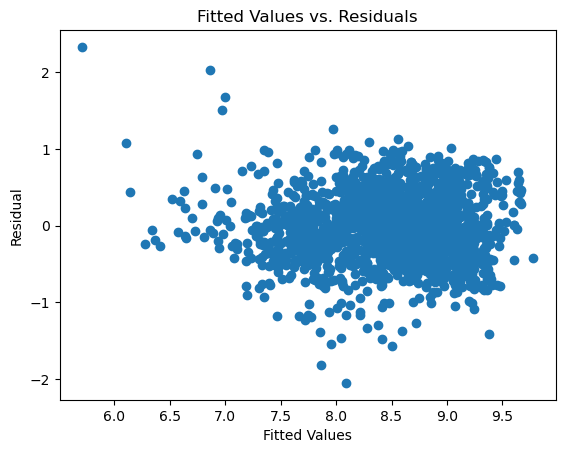

In [108]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))
p = model.fittedvalues

res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

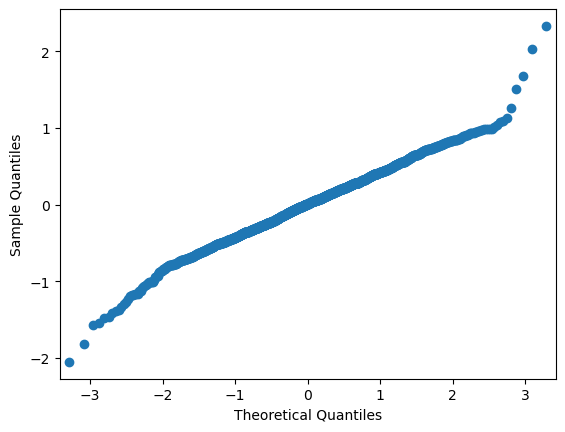

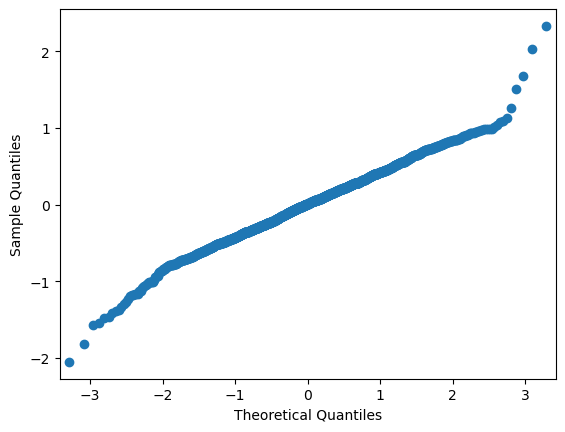

In [109]:
sm.qqplot(model.resid)

# HC3 robust standard error

https://timeseriesreasoning.com/contents/a-tutorial-on-whites-heteroskedasticity-consistent-estimator-using-python-and-statsmodels/

In [110]:
model = smf.ols('car_price_usd~kms_driven + fuel_type + transmission + manufacture + car_region + engine_vol', 
                cleaned_data_v2).fit(cov_type="HC3")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          car_price_usd   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     1385.
Date:                Mon, 09 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:15:00   Log-Likelihood:                -4036.0
No. Observations:                5417   AIC:                             8090.
Df Residuals:                    5408   BIC:                             8149.
Df Model:                           8                                         
Covariance Type:                  HC3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    -270.5116      4.356    -62.106      0.000    -279.048    -261.975
fuel_type[T.1]                 -0.5451      0.168     -3.239      0.001      -0.875      -0.215
transmission[T.Manual]         -0.8296      0.023    -36.747      0.000      -0.874      -0.785
car_region[T.Europe]            0.4266      0.025     17.321      0.000       0.378       0.475
car_region[T.North America]    -0.0997      0.033     -3.058      0.002      -0.164      -0.036
car_region[T.South Asia]       -0.1642      0.015    -11.018      0.000      -0.193      -0.135
kms_driven                   1.194e-06      2e-07      5.970      0.000    8.02e-07    1.59e-06
manufacture                     0.1388      0.002     64.324      0.000       0.135       0.143
engine_vol                      0.0001   1.33e-05      7.892      0.000    7.88e-05       0.000
==============================================================================
Omnibus:                       52.117   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.235
Skew:                          -0.158   Prob(JB):                     6.83e-15
Kurtosis:                       3.435   Cond. No.                     4.53e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 4.53e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""